In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sys
sys.path.append('../')

from src.weather_lstm import WeatherLSTM
from src.dataset import WeatherData
from src.genetic_algorithms import GeneticAlgorithms
from src.evaluation import Evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data preprocessing

The initial stage involves loading the dataset and selecting only the pertinent columns, using the Pandas library.

In [2]:
data = pd.read_csv("../data/2022.csv")
filter_cols = ["outTemp", "barometer", "dewpoint", "outHumidity", "windSpeed10"]
data = data.loc[:,filter_cols]
data.head()

,outTemp,barometer,dewpoint,outHumidity,windSpeed10
0,6.222222,1027.430167,-1.661668,57,1.609344
1,6.277778,1027.362440,-1.373265,58,3.218688
2,5.000000,1027.260848,-1.670748,62,3.218688
3,4.888889,1027.701078,-1.775836,62,1.609344
4,5.277778,1027.768806,-1.853178,60,1.609344


The dataset undergoes a two-fold process of division and scaling. This involves splitting the dataset and subsequently applying scaling, wherein the mean and standard deviation statistics computed from the training split are used to standardize the data. In essence, this step ensures that the dataset is prepared for further analysis or modeling by maintaining consistency in its numerical values across different features.

In [3]:
scaler = preprocessing.StandardScaler()

scaler.fit(data.iloc[0:4000,:]) # Standardize only the training part
scaled_data = data
scaled_data[filter_cols] = scaler.transform(data)

# Split the dataset
train_data = scaled_data.iloc[:4000]
val_data = scaled_data.iloc[4000:4500]
test_data = scaled_data.iloc[4500:]

## Genetic algorithms

This is the slowest algorithm, as the evaluation of each individual in the population involves training a LSTM model for a specified number of epochs—set to `15` in this instance. The initial population consists of `20` randomly initialized individuals, and the algorithm runs for `30` generations. The tournament size `K` is set to `3` and the number of elites preserved at each generation is set to `2`. The crossover rate $p_c$ and mutation rate $p_m$ are respectively set to $p_c=0.3$ and $p_m=0.7$. 

In [14]:
ga = GeneticAlgorithms(pop_size=20, train_data=train_data, val_data=val_data, device=device)

# Run genetic algorithms
final_pop, final_fit, fitness_evolution = ga.run(
        num_generations=30, num_elites=2, crossover_prob=0.3, mutation_prob=0.7, 
        mutation_std_dev=[10.0, 4.0, 2.0, 0.01, 0.7], maximize=False, 
        num_epochs=20, seed=3)

Generation 0
[[41, 16, 2, 0.09316093249552906, ['dewpoint', 'outHumidity', 'windSpeed10']], [35, 18, 4, 0.06991638286758341, ['barometer', 'dewpoint', 'outHumidity']], [125, 21, 2, 0.06833429684150619, ['dewpoint', 'windSpeed10']], [52, 8, 3, 0.08541213173468494, ['barometer', 'windSpeed10']], [69, 15, 3, 0.028858094705413433, ['dewpoint']], [53, 15, 1, 0.022678598860363164, ['barometer', 'outHumidity']], [47, 9, 3, 0.0469204910582053, ['barometer', 'outHumidity', 'windSpeed10']], [120, 18, 3, 0.07938438169871355, ['outHumidity']], [111, 29, 3, 0.051001635061583186, []], [115, 9, 1, 0.0428118417332814, []], [119, 6, 3, 0.07984021874492164, ['barometer', 'dewpoint', 'windSpeed10']], [69, 9, 2, 0.04068687680049029, ['outHumidity']], [19, 21, 3, 0.09412521114320288, ['barometer', 'dewpoint', 'windSpeed10']], [73, 27, 4, 0.017005622113759375, []], [94, 17, 1, 0.07115060255446551, ['outHumidity']], [31, 14, 3, 0.03875029954354417, ['barometer', 'dewpoint', 'outHumidity']], [23, 28, 2, 0.035

## Evaluation

The entire experiment takes several minutes, and the fitness progress over the generations is depicted in the following plot which illustrates the best model's fitness evaluated on the validation set at the end of each generation.

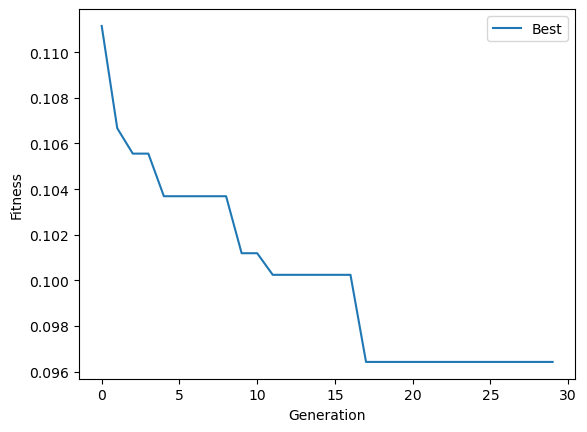

In [15]:
plt.plot(fitness_evolution["best"], label="Best")
# plt.plot(fitness_evolution["worst"], label="Worst")
# plt.plot(fitness_evolution["avg"], label="Avg")
plt.xlabel('Generation') 
plt.ylabel('Fitness') 
plt.legend()
plt.show()

In the following cell, the optimal parameters identified through Genetic Algorithms are employed to train an LSTM model with identical settings. Subsequently, the model is assessed on the entire test set, enabling a comparative analysis with other models.

In [16]:
# Get the best individual from the last population
best_individual = final_pop[np.argmin(final_fit)]
print("Best individual: " + str(best_individual))

np.random.seed(2)
model = ga.get_model(best_individual, num_epochs=20)
model.eval()

Best individual: [61, 33, 1, 0.004426126366079626, []]


WeatherLSTM(
  (lstm): LSTM(1, 33, batch_first=True)
  (linear): Linear(in_features=33, out_features=1, bias=True)
)

Now, the model is evaluated on the complete test set to facilitate comparison with other models. The outcomes reveal the superiority of the LSTM-based model over the baseline, achieving a Mean Absolute Error (MAE) of `0.08005`, which is notably smaller than the baseline method's MAE of `0.1126`.

<Figure size 640x480 with 0 Axes>

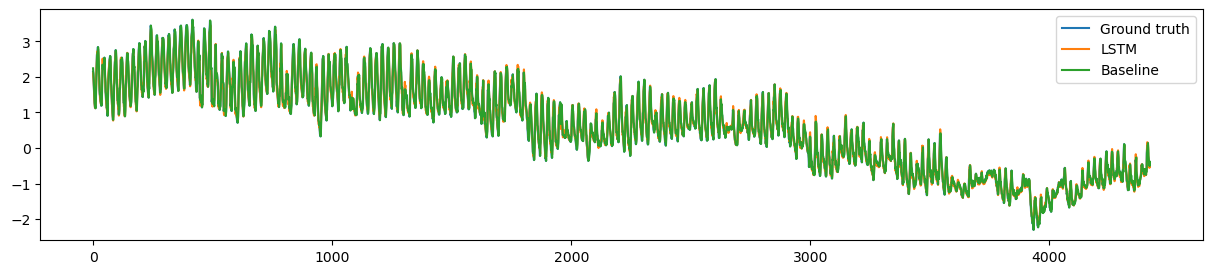

MAE LSTM: 0.080052
MAE baseline: 0.112613


In [17]:
ev = Evaluate(device=device)
mae_lstm, mae_baseline = ev.evaluateMaeLSTM(model, best_individual, test_data, plot=True)

print('MAE LSTM: %f' % (mae_lstm)) 
print('MAE baseline: %f' % (mae_baseline)) 

Ultimately, for visualization purposes, the model is evaluated on the initial `200` samples of the test dataset. The qualitative outcomes distinctly demonstrate that the model derived from hyperparameter tuning using Genetic Algorithms exhibits a closer proximity to the ground truth outdoor temperature when contrasted with the baseline.

<Figure size 640x480 with 0 Axes>

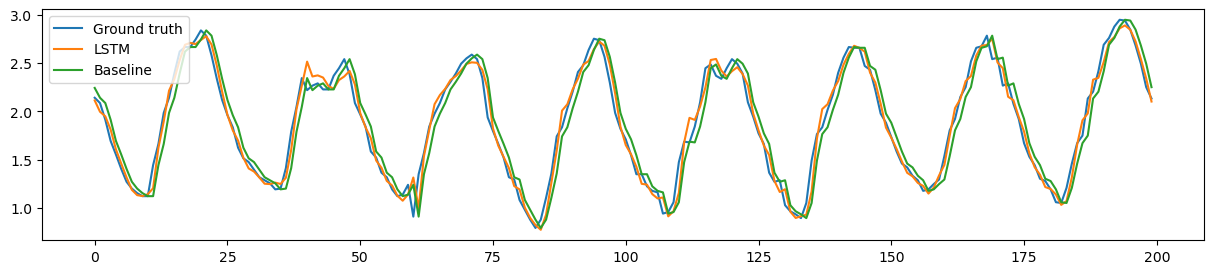

In [18]:
ev = Evaluate(device=device)
mae_lstm, mae_baseline = ev.evaluateMaeLSTM(model, best_individual, test_data[:300], plot=True)